# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres (disponible dans le premier notebook). Le deuxième exercice met en oeuvre une méthode de régression bayésienne linéaire.

### Instructions

1. Renommer votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [76]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import datasets

### Partie 2 - Régression linéaire bayésienne parcimonieuse

On suppose le modèle de régression linéaire suivant :
$$ y_i \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)$$

On a :
* $y \in \mathbb{R}$, la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$, les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$, le vecteur de régression ;
* $\sigma^2$ la variance du bruit.

Nous adoptons une approche bayésienne. Les paramètres du modèle, $\boldsymbol{\beta}$ et $\sigma^2$, doivent donc être munis d'une loi a priori.

Dans cet exercice, nous allons suivre le modèle du *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)).

Le LASSO est une méthode de régression pénalisée classique (c'est la pénalisation en norme $\ell_1$ - vous connaissez la pénalisation en norme $\ell_2$ appelée *ridge regression*). Nous regardons ici sa version bayésienne. Les lois a priori sont les suivantes :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\beta_p | \sigma^2 & \sim \text{Laplace} \left( 0, \frac{\sqrt{\sigma^2}}{\lambda} \right)
\end{align}

$\lambda$ est le paramètre de régularisation. Il se trouve qu'en prenant une loi a priori de [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) pour les coefficients de régression, le problème du LASSO est le même que celui l'estimation MAP.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est donc de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

Il n'est pas possible de dériver un échantillonneur de Gibbs immédiatement. Il se trouve que le modèle peut être ré-écrit de la manière suivante :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\tau_i^2 & \sim \text{Exp} \left( \frac{\lambda^2}{2} \right) \\
\beta_j | \tau_j^2, \sigma^2 & \sim \mathcal{N}(0, \sigma^2 \tau_j^2) \\
y_i | \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)
\end{align}

On peut alors trouver les lois conditionnelles :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1^{-2}, ..., \tau_p^{-2})$.
\begin{align}
\tau_j^{-2} | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InvGaussian}\left( \sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{IG}\left( a_0 + \frac{n+p}{2}, b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \sum_{j=1}^p \frac{\beta_j^2}{\tau_j^2} \right)
\end{align}

In [77]:
# Pre-processing the data

# Load the dataset
diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)

# Features
X = diabetes.data
X = X/np.std(X, axis = 0) # Standardize
N,P = X.shape

# Target
y = diabetes.target
y = (y-np.mean(y))/np.std(y) # Standardize

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$
* Le nombre d'échantillons $N_g$
* La taille du *burn-in* $N_b$
* Les hyper-paramètres du modèle : $a_0, b_0, \lambda$

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$.

**Attention !** Bien lire la doc. de `scipy.stats.invgauss` pour savoir quels paramètres utiliser.

In [78]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    """
    Échantillonneur de Gibbs pour la régression linéaire bayésienne parcimonieuse (Bayesian LASSO).

    Parameters:
    - X: matrice des features
    - y: vecteur de la variable cible
    - Ng: nombre d'échantillons à générer
    - Nb: taille du burn-in
    - a0, b0, l: hyperparamètres du modèle

    Returns:
    - samples: liste des échantillons du posterior (beta, tau_sq_inv, sigma_sq)
    """

    # Initialisation
    n, p = X.shape
    beta = np.zeros(p)
    tau_sq_inv = np.ones(p + 1) 
    sigma_sq = 1  # Initialisation arbitraire

    # Matrice X augmentée avec une colonne de 1 pour l'intercept
    X_augmented = np.column_stack((np.ones(n), X))

    # Boucle pour les échantillons
    samples = []
    for _ in range(Ng + Nb):
        
        # Échantillonnage de beta
        A = np.linalg.inv(np.dot(X_augmented.T, X_augmented) + np.diag(tau_sq_inv))
        beta = np.random.multivariate_normal(np.dot(A, np.dot(X_augmented.T, y)), sigma_sq * A)

        # Échantillonnage de tau_sq_inv
        tau_sq_inv[1:] = ss.invgauss.rvs(np.sqrt(l**2 * sigma_sq / beta[1:]**2), l**2)

        # Échantillonnage de sigma_sq
        residuals = y - np.dot(X_augmented, beta)
        shape_param = a0 + (n + p) / 2
        rate_param = b0 + 0.5 * np.sum(residuals**2) + 0.5 * np.sum(beta[1:]**2 / tau_sq_inv[1:])
        sigma_sq = ss.invgamma.rvs(shape_param, scale=rate_param)

        # Sauvegarde des échantillons après la période de "burn-in"
        if _ >= Nb:
            samples.append((beta, tau_sq_inv, sigma_sq))

    return samples

**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = N_b = 1000$, $a_0 = b_0 = 1$, $\lambda = 10$.

* Afficher le *traceplot* pour un paramètre de votre choix. Commenter.
* Pour chacun des paramètres $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE et MAP. Enfin, donner l'intervalle de crédibilité à 95%. (Cf. dernier chapitre du cours Intro à l'Estimation)

In [79]:
# Paramètres
Ng = 1000
Nb = 1000
a0 = 1
b0 = 1
l = 10

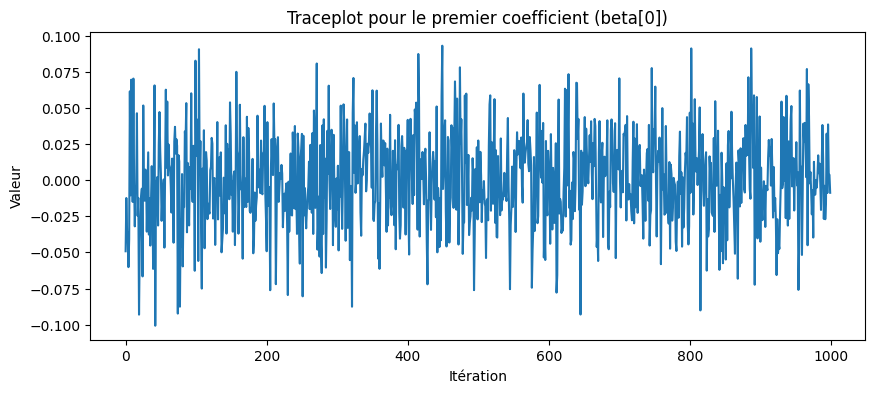

In [80]:
import time
# Faire tourner la chaîne MCMC
start = time.time()
samples = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)
time_10 = time.time() - start

# Traceplot pour un paramètre de choix
plt.figure(figsize=(10, 4))
plt.plot([sample[0][0] for sample in samples])
plt.title('Traceplot pour le premier coefficient (beta[0])')
plt.xlabel('Itération')
plt.ylabel('Valeur')
plt.show()

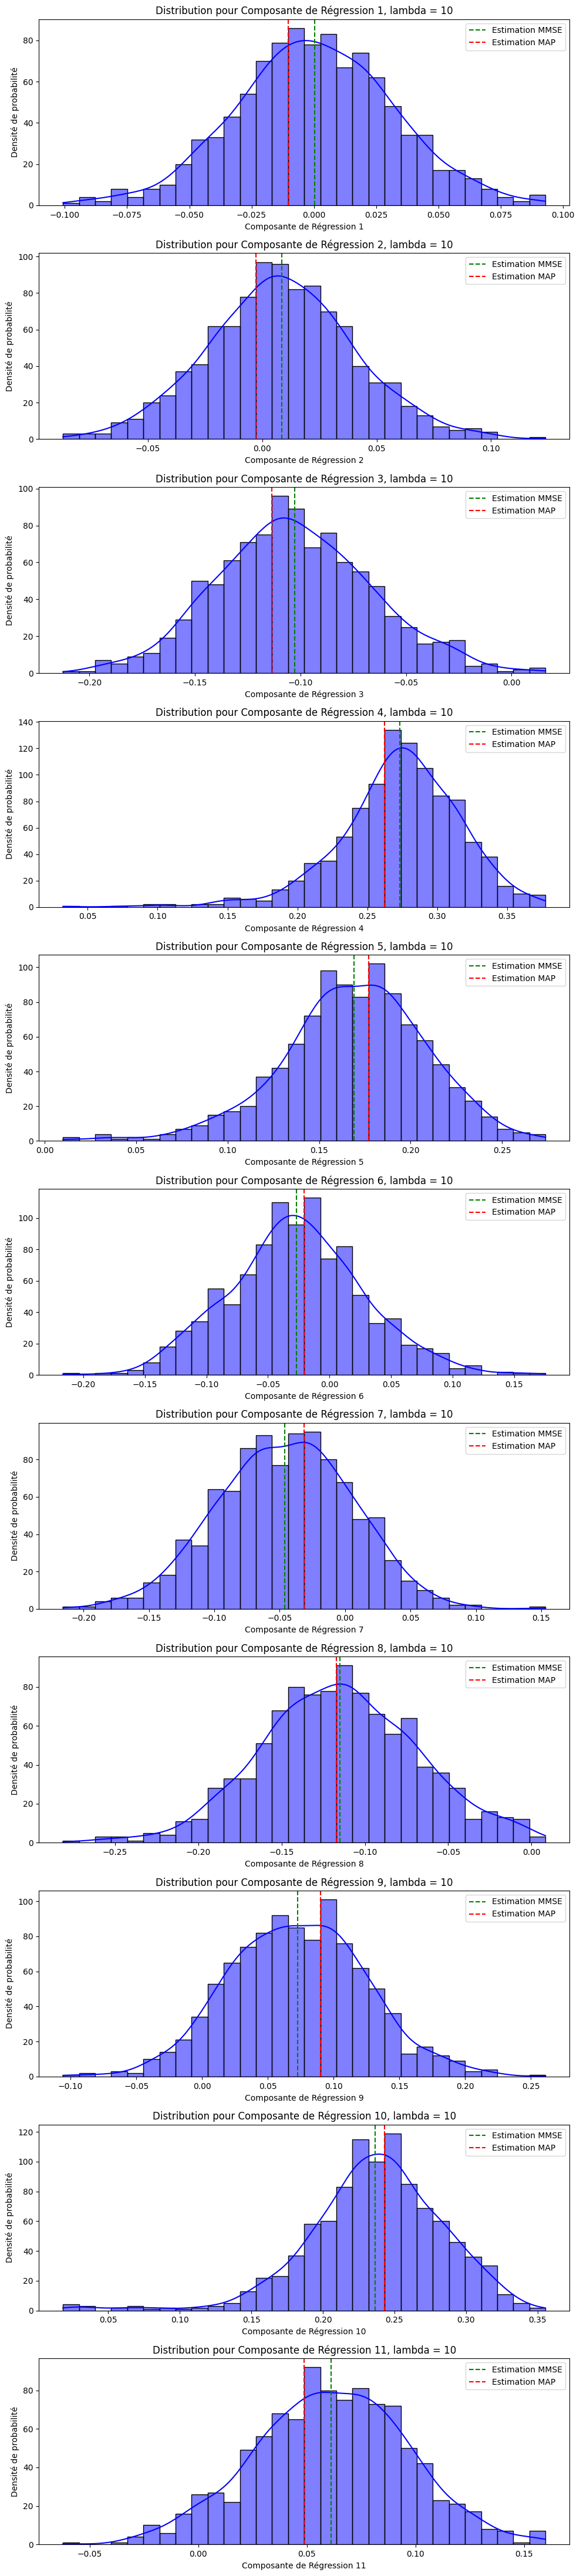

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_beta_samples(samples, l=10):

    num_components = len(samples[0][0])

    # Affichage
    fig, axes = plt.subplots(nrows=num_components, ncols=1, figsize=(10, 4*num_components))

    # Calcul MMSE pour chaque composante de beta
    mmse_estimate = np.mean([sample[0] for sample in samples], axis=0)

    # Boucle sur les composantes de beta
    for j in range(num_components):
        values = [sample[0][j] for sample in samples]

        # Histogramme
        sns.histplot(values, bins=30, kde=True, color='blue', alpha=0.5, ax=axes[j])

        # Lignes pour les estimations MMSE et MAP
        axes[j].axvline(x=mmse_estimate[j], color='green', linestyle='dashed', label='Estimation MMSE')

        # Calcul MAP 
        # Indice du bin avec la plus grande fréquence
        max_bin_index = np.argmax(np.histogram(values, bins=30)[0])
        # On obtient la valeur correspondante
        map_value = np.histogram(values, bins=30)[1][max_bin_index]
        # On trace la ligne associée
        axes[j].axvline(x=map_value, color='red', linestyle='dashed', label='Estimation MAP')

        axes[j].set_title(f'Distribution pour Composante de Régression {j+1}, lambda = {l}')
        axes[j].set_xlabel(f'Composante de Régression {j+1}')
        axes[j].set_ylabel('Densité de probabilité')
        axes[j].legend()

    plt.tight_layout()
    plt.savefig(f"img/densite_de_probabilite_pour_chaque_composante_beta_lambda{l}.png")
    plt.show()
plot_beta_samples(samples)

Nous avons 11 composantes car nous avons décidé d'ajouter l'intercept. On observe d'ailleurs que cet intercept est très petit et c'est normal car nous avons normalisé nos données. Par principe, nous avons décidé de le garder pour la suite.

Ensuite, en ce qui concerne la forme des distributions, elles ressemblent à une distribution normale, cela peut indiquer que l'algorithme a convergé vers une estimation stable des paramètres. De plus, lorsqu'on compare les estimations MMSE et MAP, ils sont proches ce qui signifie que nos distributions sont symétriques et centrées.

In [82]:
def intervalle_credibilite(samples):
    # Calcul des quantiles à 2.5% et 97.5% pour un intervalle de crédibilité à 95%
    lower_bound = np.percentile([sample[0] for sample in samples], 2.5, axis=0)
    upper_bound = np.percentile([sample[0] for sample in samples], 97.5, axis=0)
    return lower_bound, upper_bound

In [83]:
l, u = intervalle_credibilite(samples)
# Affichage de l'intervalle de crédibilité
for i in range(len(l)):
    print(f"Intervalle de crédibilité à 95% pour l'échantillon {i+1}: [{l[i]}, {u[i]}]")

Intervalle de crédibilité à 95% pour l'échantillon 1: [-0.06263314906625082, 0.0633345893778449]
Intervalle de crédibilité à 95% pour l'échantillon 2: [-0.05302562846872402, 0.07255447428969672]
Intervalle de crédibilité à 95% pour l'échantillon 3: [-0.17169811574177693, -0.027290100023106015]
Intervalle de crédibilité à 95% pour l'échantillon 4: [0.17575329558291514, 0.34924938497140734]
Intervalle de crédibilité à 95% pour l'échantillon 5: [0.08425308439116024, 0.24073733032922323]
Intervalle de crédibilité à 95% pour l'échantillon 6: [-0.12998219210547177, 0.0866365706762287]
Intervalle de crédibilité à 95% pour l'échantillon 7: [-0.14633190870313664, 0.04925800466492439]
Intervalle de crédibilité à 95% pour l'échantillon 8: [-0.20599840497998406, -0.018711796267181897]
Intervalle de crédibilité à 95% pour l'échantillon 9: [-0.028125906336933165, 0.17714689676099726]
Intervalle de crédibilité à 95% pour l'échantillon 10: [0.14076555133282567, 0.31904544802260865]
Intervalle de crédi

Au niveau des intervalles de crédibilité, on peut voir que nos estimations MMSE et MAP sont toutes comprises dans l'intervalle de crédibilité à 95%.

In [84]:
# Calculer les estimations MMSE et MAP pour sigma^2
mmse_estimate_sigma = np.mean([sample[2] for sample in samples])
# map_estimate_sigma = np.mean([sample[2] for sample in samples]) 

values_sigma = [sample[2] for sample in samples]
map_estimate_sigma_index = np.argmax(np.histogram(values_sigma, bins = 30)[0])
map_estimate_sigma = np.histogram(values_sigma, bins=30)[1][map_estimate_sigma_index]

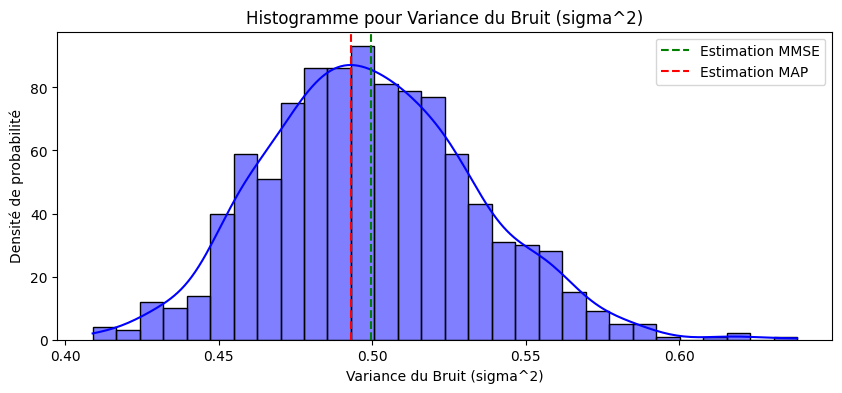

In [85]:
# Pour sigma^2
values_sigma = [sample[2] for sample in samples]  # Indice 2 car sigma^2 est le troisième élément dans chaque échantillon
plt.figure(figsize=(10, 4))
sns.histplot(values_sigma, bins=30, kde=True, color='blue', alpha=0.5)
plt.axvline(x=mmse_estimate_sigma, color='green', linestyle='dashed', label='Estimation MMSE')
plt.axvline(x=map_estimate_sigma, color='red', linestyle='dashed', label='Estimation MAP')
plt.title('Histogramme pour Variance du Bruit (sigma^2)')
plt.xlabel('Variance du Bruit (sigma^2)')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.savefig("img/histogramme_variance_sigma_carre.png")
plt.show()

On peut tirer du graphe ci-dessus les mêmes conclusions que celles sur beta, à savoir la convergence vers une estimation stable des paramètres. De plus, le MAP et le MMSE sont quasiment identiques, notre distribution est donc encore symétrique et centrée.

**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

Pour générer les échantillons de la loi prédictive à posteriori, on va se servir des valeurs de $\beta$ et $\sigma$ obtenues grâce à l'exécution de l'algorithme de Gibbs.

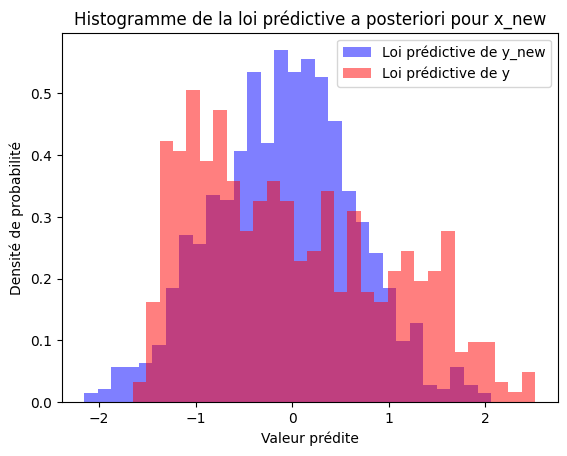

In [86]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])

# Nombre d'échantillons
num_samples = 1000

# Échantillons de la loi prédictive a posteriori
predictive_samples = []

for sample in samples:
    beta, tau_sq_inv, sigma_sq = sample
    # Calcul de la prédiction
    x_new_augmented = np.array([1] + list(x_new))
    y_pred = np.random.normal(np.dot(x_new_augmented, beta), np.sqrt(sigma_sq))
    
    predictive_samples.append(y_pred)

predictive_samples = np.array(predictive_samples)

# Tracé d'un histogramme 
plt.hist(predictive_samples, bins=30, density=True, color='blue', alpha=0.5, label='Loi prédictive de y_new')
plt.hist(y, bins=30, density=True, color='red', alpha=0.5, label='Loi prédictive de y')
plt.title('Histogramme de la loi prédictive a posteriori pour x_new')
plt.xlabel('Valeur prédite')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.savefig("img/histogramme_y_new_y.png")
plt.show()

On peut donc observer que pour ces nouvelles valeurs $x_{new}$, la loi prédictive à posteriori $y_{new}$ est répartie de manière différente par rapport à $y$. Cela peut s'expliquer par les différences dans les datas entre $x$ et $x_{new}$ (notamment la différence de taille).

**Q4.** Étudier l'influence du paramètre lambda sur l'inférence des paramètres.

Sans l'implémenter, à l'aide de vos connaissances, pouvez-vous proposer une méthode permettant de choisir lambda ?

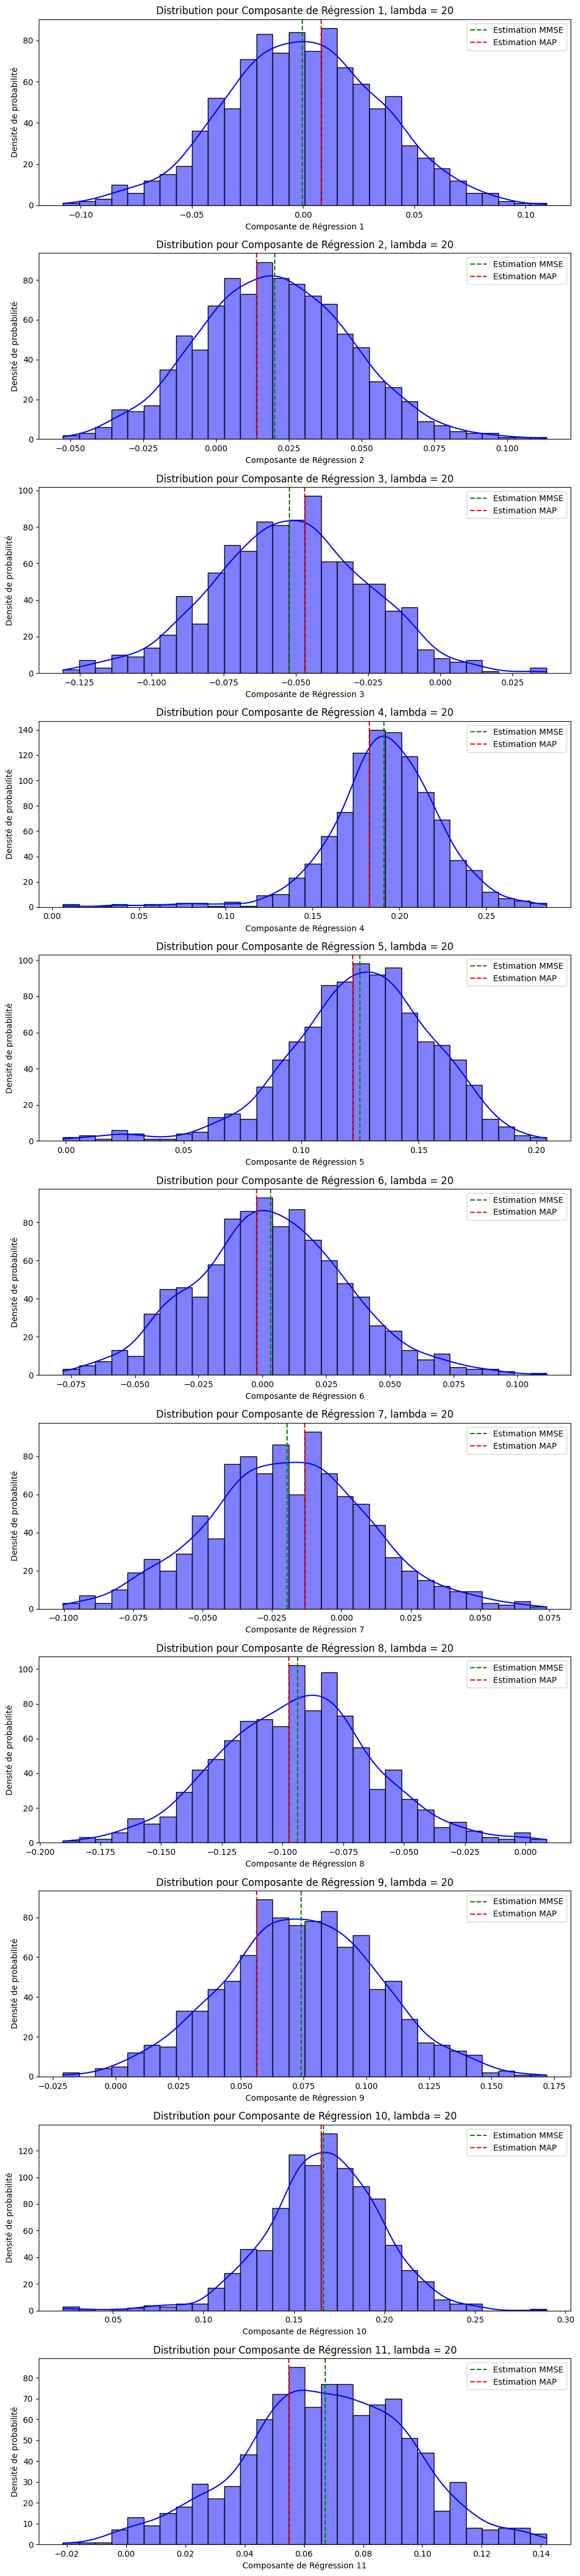

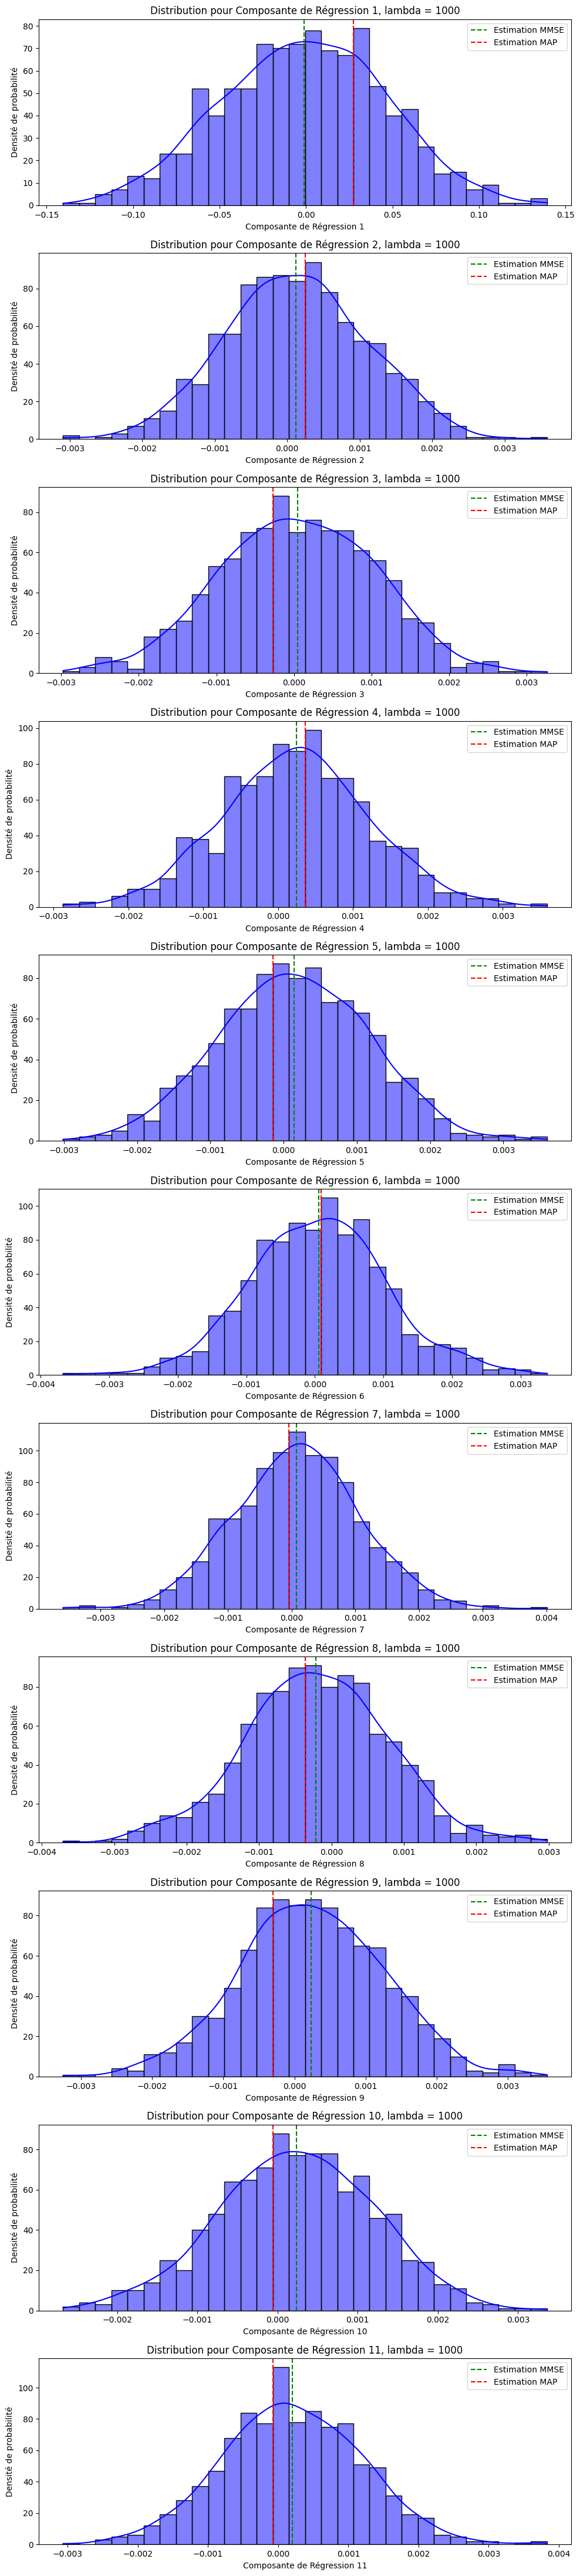

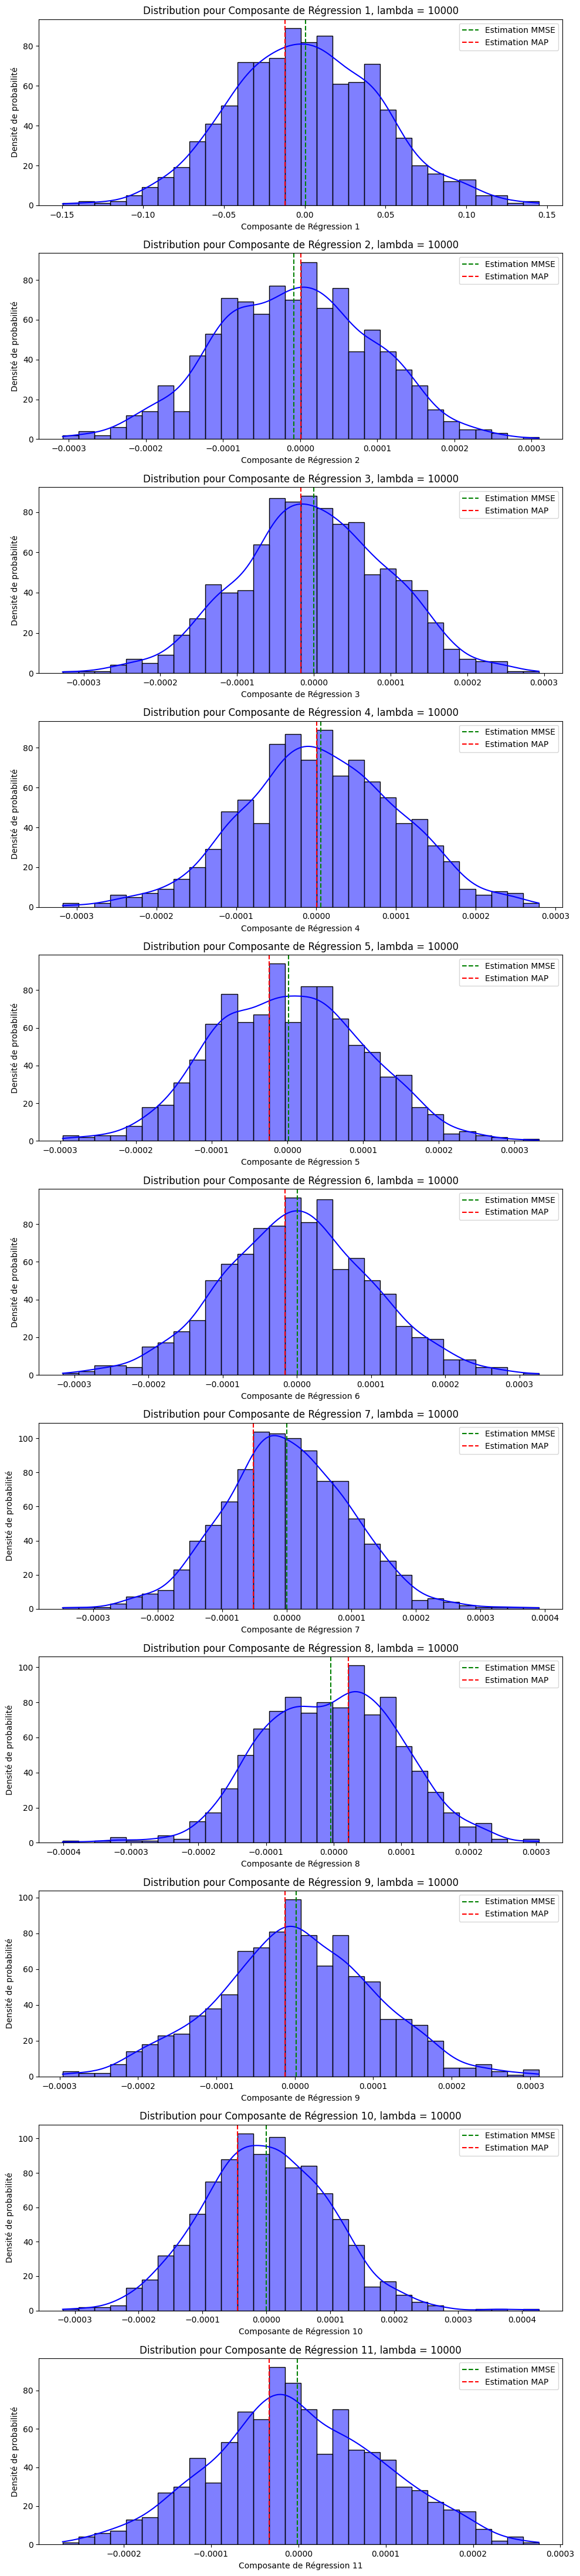

In [87]:

start = time.time()
samples_20 = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, 20)
time_20 = time.time() - start

start = time.time()
samples_1000 = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, 1000)
time_1000 = time.time() - start

start = time.time()
samples_10000 = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, 10000)
time_10000 = time.time() - start

plot_beta_samples(samples_20, 20)
plot_beta_samples(samples_1000, 1000)
plot_beta_samples(samples_10000, 10000)

D'après les graphes ci-dessus (pour lambda = 20, 1000 puis 10000), on peut observer que plus lambda augmente, plus la densité de probabilité représentant $\beta$ se centre sur 0, et plus l'ensemble des valeurs de $\beta$ sont dans un intervalle restreint. Nous allons maintenant regarder l'évolution de l'intervalle de crédibilité, pour finaliser notre analyse.

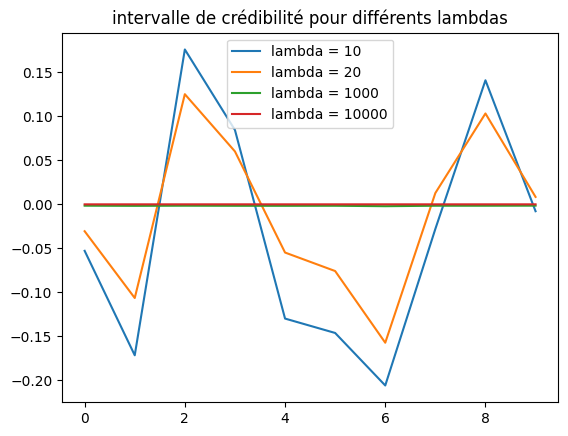

In [88]:
l20, u20 = intervalle_credibilite(samples_20)

l1000, u1000 = intervalle_credibilite(samples_1000)

l10000, u10000 = intervalle_credibilite(samples_10000)

plt.plot(l[1:], label = "lambda = 10")
plt.plot(l20[1:], label = "lambda = 20")
plt.plot(l1000[1:], label = "lambda = 1000")
plt.plot(l10000[1:], label = "lambda = 10000")
plt.title("intervalle de crédibilité pour différents lambdas")
plt.legend()
plt.savefig("img/intervalle_credibilite.png")
plt.show()

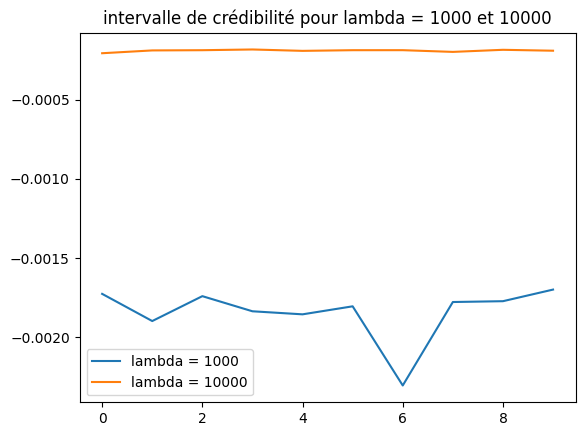

In [89]:
plt.plot(l1000[1:], label = "lambda = 1000")
plt.plot(l10000[1:], label = "lambda = 10000")
plt.title("intervalle de crédibilité pour lambda = 1000 et 10000")
plt.legend()
plt.savefig("img/intervalle_credibilite_lambda_1000_10000.png")
plt.show()

On peut donc observer que pour lambda = 1000 et 10000, l'intervalle de crédibilité est bien moins important que pour lambda = 10 ou 20. On en déduit donc que plus lambda augmente, plus on a une estimation précise de notre valeur.

In [90]:
print("Temps d'exécution pour lambda = 10 :",time_10)
print("Temps d'exécution pour lambda = 20 :",time_20)
print("Temps d'exécution pour lambda = 1000 :",time_1000)
print("Temps d'exécution pour lambda = 10000 :", time_10000)

Temps d'exécution pour lambda = 10 : 1.352593183517456
Temps d'exécution pour lambda = 20 : 1.2578179836273193
Temps d'exécution pour lambda = 1000 : 1.3592298030853271
Temps d'exécution pour lambda = 10000 : 1.0757081508636475


On peut voir que de manière assez surprenante, le temps d'exécution semble diminuer lorsque lambda augmente !  
Pour sélectionner la valeur du lambda "optimal", on peut alors penser à réaliser une cross validation, qui consiste à séparer nos données d'entrainement en K différents sous-ensembles, dont un est utilisé comme ensemble de test et les autres sont utilisés pour entrainer notre modèle. On répète le processus K fois, en changeant à chaque itération l'ensemble de test.  
En donnant une plage de valeurs pour notre pénalité, on peut grâce à la CV sélectionner la pénalité où l'erreur de prédiction est la moins importante, ce qui correpondra à notre pénalité optimale.

**Questions bonus**. Le TP est déjà long. Votre objectif premier est d'effectuer les questions précédentes correctement.

S'il vous reste du temps et de la motivation, voici deux questions "papier-crayon" :
* Montrer que l'estimation MAP dans un modèle avec un *prior* Laplace pour les coefficients de régression mène bien au même problème que le LASSO
* Dériver la loi conditionnelle pour $\boldsymbol{\beta}$ ou $\sigma^2$. Attention ! Le calcul de la loi conditionnelle de $\tau_i$ est quant à lui très compliqué. Ne le tentez pas sans l'aide d'un(e) professionnel(le).